In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.api import Logit, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, levene, f_oneway, kruskal
import scikit_posthocs as sp

In [2]:
CSV_PATH = 'output/uber_rides_enriched.csv'

In [3]:
df = pd.read_csv(
        CSV_PATH,
        parse_dates=['start_at','end_at','arrived_at','time_grid'],
    )

# Localizamos las fechas en la zona horaria de Lima
for col in ['start_at', 'end_at', 'arrived_at', 'time_grid']:
    df[col] = df[col].dt.tz_localize(
        'America/Lima',
        ambiguous='NaT',
        nonexistent='shift_forward'
    )

In [4]:
df.drop(
    columns=[
        'duration',
        'distance'
    ],
    inplace=True
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23111 entries, 0 to 23110
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype                       
---  ------                  --------------  -----                       
 0   user_id                 23111 non-null  object                      
 1   driver_id               19726 non-null  object                      
 2   icon                    23111 non-null  object                      
 3   start_type              23111 non-null  object                      
 4   start_at                23111 non-null  datetime64[ns, America/Lima]
 5   start_lat               22212 non-null  float64                     
 6   start_lon               22212 non-null  float64                     
 7   end_at                  22835 non-null  datetime64[ns, America/Lima]
 8   end_lat                 22212 non-null  float64                     
 9   end_lon                 22212 non-null  float64                     
 10

In [6]:
# Filas con coordenadas nulas y end_state == 'drop off'
mask = (
    df['start_lat'].isna() &
    (df['end_state'] == 'drop off')
)

# Cuántas filas son
print(f"Se eliminan {mask.sum()} ({mask.sum()/len(df):.2%}) filas de un total de {len(df)}")

# Eliminar esas filas
df = df.loc[~mask].copy()

Se eliminan 533 (2.31%) filas de un total de 23111


In [7]:
df_drop = df[
    df.end_state == 'drop off'
].copy()

df_n = df[
    ~(df.end_state == 'drop off')
].drop(
    columns=[
        'end_lat',
        'end_lon',
        'arrived_at',
        'price_distance',
        'price_duration',
        'cost',
        'cost_distance',
        'cost_duration',
        'driver_score',
        'rider_score',
        'dist_start_to_end_m',
        'time_start_to_end_s',
    ]
).copy()

In [8]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16884 entries, 0 to 23108
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype                       
---  ------                  --------------  -----                       
 0   user_id                 16884 non-null  object                      
 1   driver_id               16884 non-null  object                      
 2   icon                    16884 non-null  object                      
 3   start_type              16884 non-null  object                      
 4   start_at                16884 non-null  datetime64[ns, America/Lima]
 5   start_lat               16884 non-null  float64                     
 6   start_lon               16884 non-null  float64                     
 7   end_at                  16880 non-null  datetime64[ns, America/Lima]
 8   end_lat                 16884 non-null  float64                     
 9   end_lon                 16884 non-null  float64                     
 10  end

In [9]:
# Series de valores calculados
t_api_wait = df_drop['time_driver_to_start_s']
t_calc_wait = (df_drop['arrived_at'] - df_drop['start_at']).dt.total_seconds().clip(lower=0)

t_api_trip = df_drop['time_start_to_end_s']
t_calc_trip = (
    df_drop['end_at']
    - pd.DataFrame({'1': df_drop['start_at'], '2': df_drop['arrived_at']})
      .max(axis=1)
)
t_calc_trip = t_calc_trip.dt.total_seconds()

# Error porcentual
err_wait_pct = (t_api_wait - t_calc_wait).abs() / t_api_wait * 100
err_trip_pct = (t_api_trip - t_calc_trip).abs() / t_api_trip * 100

# Umbral del 20%
mask_wait = err_wait_pct > 50
mask_trip = err_trip_pct > 50
mask_any  = mask_wait | mask_trip

# Imprimir conteos
print(f"Valores de espera a reemplazar por API: {mask_wait.sum()}")
print(f"Valores de viaje a reemplazar por API: {mask_trip.sum()}")
print(f"Total de filas a usar dato de API: {mask_any.sum()}")

# DataFrame de filas para reemplazo
df_flag = df_drop.loc[mask_any].copy()
df_flag['err_wait_pct'] = err_wait_pct[mask_any]
df_flag['err_trip_pct'] = err_trip_pct[mask_any]


Valores de espera a reemplazar por API: 10519
Valores de viaje a reemplazar por API: 9034
Total de filas a usar dato de API: 13537


In [10]:
# Reemplazar las columnas de fechas por NaT en las filas que superen el umbral
#   Para las discrepancias de espera, anulamos 'arrived_at' (así falla el cálculo de espera).
df_drop.loc[mask_wait, ['arrived_at']] = pd.NaT

#   Para las discrepancias de trayecto, anulamos 'end_at' (así falla el cálculo de duración de viaje).
df_drop.loc[mask_trip, ['end_at']]      = pd.NaT

# Verificación
print(f"Filas modificadas: {mask_any.sum()}")


Filas modificadas: 13537

In [11]:
df_drop['hour'] = df_drop['start_at'].dt.hour
df_drop['weekday'] = df_drop['start_at'].dt.weekday      # 0=Lunes … 6=Domingo
df_drop['weekday_name'] = df_drop['start_at'].dt.day_name()

In [12]:
# --- 1) Crear wait_calc y trip_calc ---
df_drop['wait_calc'] = (
    df_drop['arrived_at'] - df_drop['start_at']
).dt.total_seconds().clip(lower=0)
df_drop['trip_calc'] = (
    df_drop['end_at']
    - pd.DataFrame({'1': df_drop['start_at'], '2': df_drop['arrived_at']})
      .max(axis=1)
).dt.total_seconds()

In [13]:
def select_features(
    df, candidates, target,
    corr_thresh=0.1,
    imp_cum_thresh=0.9,
    vif_thresh=10,
    miss_pval=0.05,
    min_complete_cases=20
):
    print(f"\n--- Selecting features for target '{target}' ---")
    # 1) DataFrame de casos completos para este target
    cols_fc = candidates + [target]
    df_comp = df[cols_fc].dropna()
    print(f"Complete cases for '{target}': {df_comp.shape[0]} rows")
    if df_comp.shape[0] < min_complete_cases:
        print(f"  Not enough complete cases (<{min_complete_cases}); returning all candidates.")
        return candidates.copy()

    # 2) Missingness (Logistic MAR test)
    flag = df[target].isna().astype(int)
    X_miss = df[candidates].fillna(df[candidates].median())
    try:
        logit = Logit(flag, add_constant(X_miss)).fit(disp=False)
        pvals = logit.pvalues.drop('const', errors='ignore')
        miss_preds = pvals[pvals < miss_pval].index.tolist()
        print(f"Predictors of missingness (p < {miss_pval}): {miss_preds}")
    except Exception as e:
        miss_preds = []
        print(f"  Could not run MAR test: {e}")

    # 3) Univariate correlation
    corrs = df_comp.corr()[target].abs().drop(target)
    corr_preds = corrs[corrs >= corr_thresh].index.tolist()
    print(f"Predictors by correlation ≥ {corr_thresh}: {corr_preds}")

    # 4) Initial union
    init_preds = list(dict.fromkeys(miss_preds + corr_preds))
    if not init_preds:
        init_preds = candidates.copy()
        print("  No predictors from MAR/corr; using all candidates.")
    print(f"Initial candidate predictors: {init_preds}")

    # 5) RandomForest importances
    X_rf, y_rf = df_comp[init_preds], df_comp[target]
    rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    rf.fit(X_rf, y_rf)
    imp = pd.Series(rf.feature_importances_, index=init_preds).sort_values(ascending=False)
    cum_imp = imp.cumsum()
    # select features up to cumulative importance threshold
    sel = cum_imp[cum_imp <= imp_cum_thresh].index.tolist()
    remaining = [f for f in imp.index if f not in sel]
    if remaining and (cum_imp.iloc[len(sel)] < imp_cum_thresh):
        sel.append(remaining[0])
    if not sel:
        sel = init_preds.copy()
        print("  No features passed importance threshold; falling back to init_preds.")

    print("RandomForest importances and cumulative sums:")
    for feat, importance in imp.items():
        print(f"  {feat}: {importance:.4f} (cumulative: {cum_imp[feat]:.4f})")
    print(f"Selected by importance (cum ≤ {imp_cum_thresh}): {sel}")
    if remaining:
        print(f"Dropped by importance: {remaining}")

    # 6) VIF filtering, dropping the least-important among high-VIF features
    features = sel.copy()
    if len(features) > 1:
        try:
            def compute_vif_matrix(X, feats):
                arr = X[feats].dropna().values
                return pd.Series(
                    [variance_inflation_factor(arr, i) for i in range(len(feats))],
                    index=feats
                )

            mat = df_comp[features].dropna().values
            if mat.shape[0] > mat.shape[1]:
                print(f"Starting VIF filtering (threshold={vif_thresh}) on: {features}")
                vif_series = compute_vif_matrix(df_comp, features)
                while True:
                    high_vif = vif_series[vif_series > vif_thresh]
                    if high_vif.empty or len(features) == 1:
                        print("  No further VIF > threshold; done.")
                        break

                    # drop the high-VIF feature with the lowest RF importance
                    to_drop = imp.loc[high_vif.index].idxmin()
                    print(f"  Dropping '{to_drop}' (VIF={vif_series[to_drop]:.1f}, lowest imp={imp[to_drop]:.4f})")
                    features.remove(to_drop)

                    mat = df_comp[features].dropna().values
                    if mat.shape[0] <= mat.shape[1]:
                        print("  Insufficient rows for further VIF; stopping.")
                        break
                    vif_series = compute_vif_matrix(df_comp, features)

                print(f"Features after VIF filtering: {features}")
            else:
                print("  Skipping VIF: not enough complete rows vs. features.")
        except Exception as e:
            print(f"  Skipping VIF due to error: {e}")
    else:
        print("  Skipping VIF: need at least 2 features to compute.")

    return features


In [14]:
wait_candidates = [
    'time_driver_to_start_s',      # API’s estimate of driver travel
    'dist_driver_to_start_m',      # distance driver→pickup
    'hour', 'weekday',             # temporal context at request
    't2m', 'tp', 'u10', 'v10'  # weather at request
]

trip_candidates = [
    'time_start_to_end_s',         # API’s estimate of trip
    'dist_start_to_end_m',         # distance pickup→dropoff
    'hour', 'weekday',             # temporal context at pickup
    't2m', 'tp', 'u10', 'v10'  # weather at pickup
]


# --- 4) Ejecutar selección para cada target ---
wait_features = select_features(df_drop, wait_candidates, 'wait_calc')
trip_features = select_features(df_drop, trip_candidates, 'trip_calc')

print("Features selected for wait_calc:")
print(wait_features)
print("\nFeatures selected for trip_calc:")
print(trip_features)



--- Selecting features for target 'wait_calc' ---
Complete cases for 'wait_calc': 304 rows


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictors of missingness (p < 0.05): ['time_driver_to_start_s', 'dist_driver_to_start_m', 'hour', 'weekday', 't2m', 'tp', 'v10']
Predictors by correlation ≥ 0.1: ['time_driver_to_start_s', 'dist_driver_to_start_m', 'hour', 'weekday', 't2m', 'u10', 'v10']
Initial candidate predictors: ['time_driver_to_start_s', 'dist_driver_to_start_m', 'hour', 'weekday', 't2m', 'tp', 'v10', 'u10']
RandomForest importances and cumulative sums:
  time_driver_to_start_s: 0.6803 (cumulative: 0.6803)
  dist_driver_to_start_m: 0.2095 (cumulative: 0.8898)
  u10: 0.0286 (cumulative: 0.9184)
  t2m: 0.0251 (cumulative: 0.9435)
  v10: 0.0250 (cumulative: 0.9685)
  tp: 0.0176 (cumulative: 0.9862)
  weekday: 0.0083 (cumulative: 0.9945)
  hour: 0.0055 (cumulative: 1.0000)
Selected by importance (cum ≤ 0.9): ['time_driver_to_start_s', 'dist_driver_to_start_m']
Dropped by importance: ['u10', 't2m', 'v10', 'tp', 'weekday', 'hour']
Starting VIF filtering (threshold=10) on: ['time_driver_to_start_s', 'dist_driver_to_sta

c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictors of missingness (p < 0.05): ['time_start_to_end_s', 'dist_start_to_end_m', 'hour', 'weekday', 'tp']
Predictors by correlation ≥ 0.1: ['time_start_to_end_s', 'dist_start_to_end_m', 'hour', 't2m', 'tp', 'u10']
Initial candidate predictors: ['time_start_to_end_s', 'dist_start_to_end_m', 'hour', 'weekday', 'tp', 't2m', 'u10']
RandomForest importances and cumulative sums:
  time_start_to_end_s: 0.3641 (cumulative: 0.3641)
  dist_start_to_end_m: 0.2975 (cumulative: 0.6616)
  u10: 0.1084 (cumulative: 0.7700)
  t2m: 0.0761 (cumulative: 0.8462)
  tp: 0.0664 (cumulative: 0.9125)
  weekday: 0.0505 (cumulative: 0.9630)
  hour: 0.0370 (cumulative: 1.0000)
Selected by importance (cum ≤ 0.9): ['time_start_to_end_s', 'dist_start_to_end_m', 'u10', 't2m']
Dropped by importance: ['tp', 'weekday', 'hour']
Starting VIF filtering (threshold=10) on: ['time_start_to_end_s', 'dist_start_to_end_m', 'u10', 't2m']
  Dropping 't2m' (VIF=10.3, lowest imp=0.0761)
  Dropping 'dist_start_to_end_m' (VIF=15.2,

In [15]:
wait_feats = wait_features + ['wait_calc']
trip_features.remove('u10')
trip_feats = trip_features + ['trip_calc']

# 2) Configure imputers
imp_wait = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
    max_iter=10,
    random_state=0
)
imp_trip = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
    max_iter=10,
    random_state=0
)

# 3) Fit & transform wait_calc
wait_array = imp_wait.fit_transform(df_drop[wait_feats])
df_drop['wait_calc'] = wait_array[:, wait_feats.index('wait_calc')]

# 4) Fit & transform trip_calc
trip_array = imp_trip.fit_transform(df_drop[trip_feats])
df_drop['trip_calc'] = trip_array[:, trip_feats.index('trip_calc')]

# 5) Reconstruct arrived_at where needed
mask_arr = df_drop['arrived_at'].isna()
df_drop.loc[mask_arr, 'arrived_at'] = (
    df_drop.loc[mask_arr, 'start_at']
    + pd.to_timedelta(df_drop.loc[mask_arr, 'wait_calc'], unit='s')
)

# 6) Reconstruct end_at where needed
trip_start = pd.DataFrame({
    '1': df_drop['start_at'],
    '2': df_drop['arrived_at']
}).max(axis=1)
mask_end = df_drop['end_at'].isna()
df_drop.loc[mask_end, 'end_at'] = (
    trip_start.loc[mask_end]
    + pd.to_timedelta(df_drop.loc[mask_end, 'trip_calc'], unit='s')
)

# 7) Report
print(f"wait_calc was imputed in {mask_arr.sum()} rows")
print(f"trip_calc was imputed in {mask_end.sum()} rows")


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


wait_calc was imputed in 10520 rows
trip_calc was imputed in 9038 rows


In [16]:
# Series de valores calculados
t_api_wait = df_drop['time_driver_to_start_s']
t_calc_wait = (df_drop['arrived_at'] - df_drop['start_at']).dt.total_seconds().clip(lower=0)

t_api_trip = df_drop['time_start_to_end_s']
t_calc_trip = (
    df_drop['end_at']
    - pd.DataFrame({'1': df_drop['start_at'], '2': df_drop['arrived_at']})
      .max(axis=1)
)
t_calc_trip = t_calc_trip.dt.total_seconds()

# Error porcentual
err_wait_pct = (t_api_wait - t_calc_wait).abs() / t_api_wait * 100
err_trip_pct = (t_api_trip - t_calc_trip).abs() / t_api_trip * 100

# Umbral del 20%
mask_wait = err_wait_pct > 50
mask_trip = err_trip_pct > 50
mask_any  = mask_wait | mask_trip

# Imprimir conteos
print(f"Valores de espera a reemplazar por API: {mask_wait.sum()}")
print(f"Valores de viaje a reemplazar por API: {mask_trip.sum()}")
print(f"Total de filas a usar dato de API: {mask_any.sum()}")

# DataFrame de filas para reemplazo
df_flag = df_drop.loc[mask_any].copy()
df_flag['err_wait_pct'] = err_wait_pct[mask_any]
df_flag['err_trip_pct'] = err_trip_pct[mask_any]


Valores de espera a reemplazar por API: 421
Valores de viaje a reemplazar por API: 4284
Total de filas a usar dato de API: 4602


In [17]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16884 entries, 0 to 23108
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype                       
---  ------                  --------------  -----                       
 0   user_id                 16884 non-null  object                      
 1   driver_id               16884 non-null  object                      
 2   icon                    16884 non-null  object                      
 3   start_type              16884 non-null  object                      
 4   start_at                16884 non-null  datetime64[ns, America/Lima]
 5   start_lat               16884 non-null  float64                     
 6   start_lon               16884 non-null  float64                     
 7   end_at                  16884 non-null  datetime64[ns, America/Lima]
 8   end_lat                 16884 non-null  float64                     
 9   end_lon                 16884 non-null  float64                     
 10  end

In [18]:
cuantitativas = ['price','price_distance','price_duration','cost','cost_duration','cost_distance','dist_driver_to_start_m','time_driver_to_start_s','dist_start_to_end_m','time_start_to_end_s','wait_calc','trip_calc','u10','v10','tcc','tp']
cualitativas = ['icon','start_type','end_state','source','driver_score','rider_score','hour','weekday']

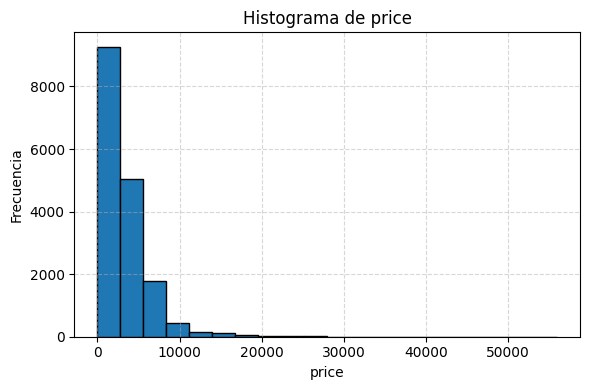

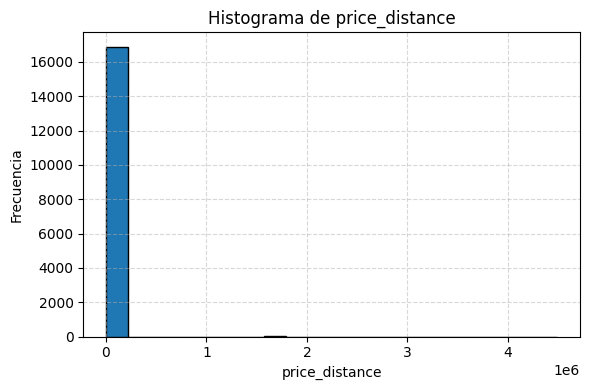

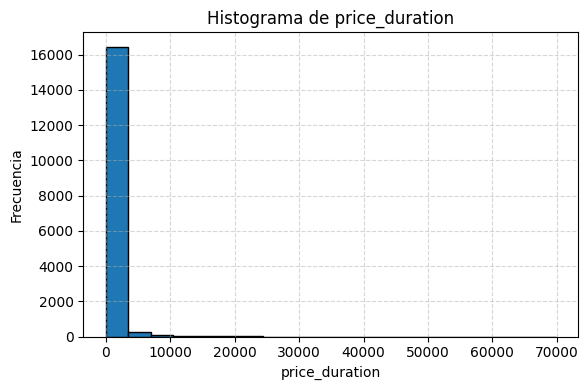

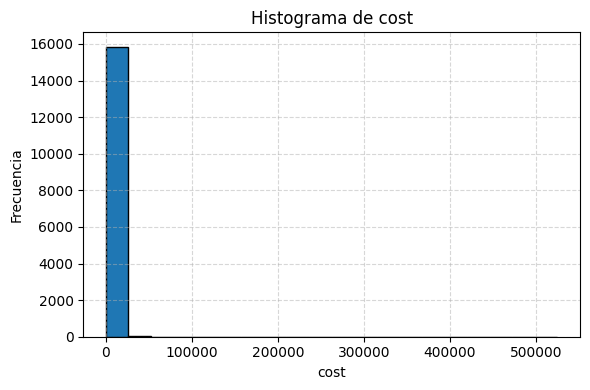

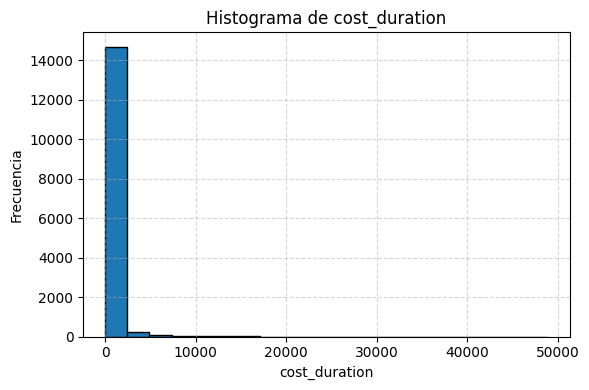

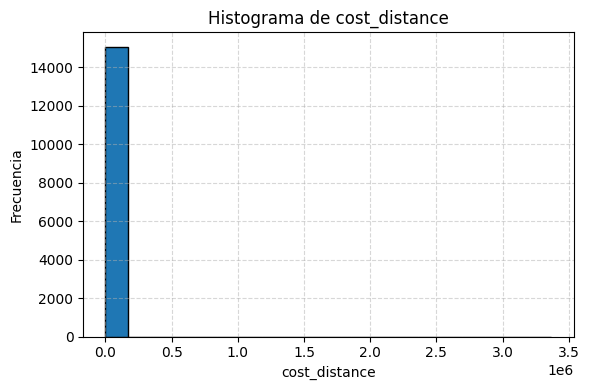

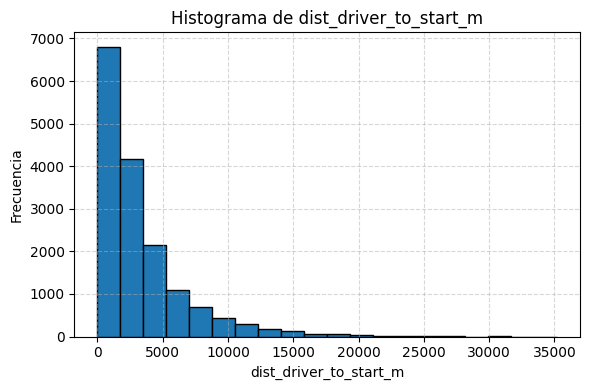

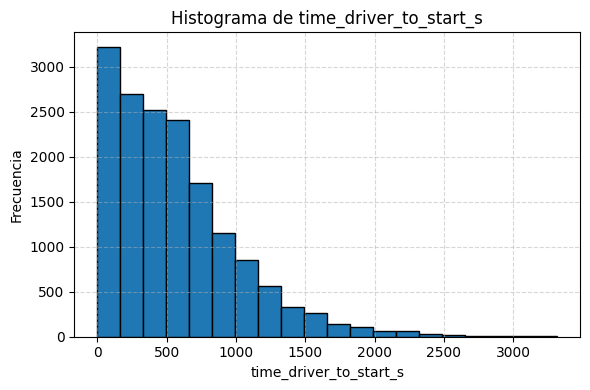

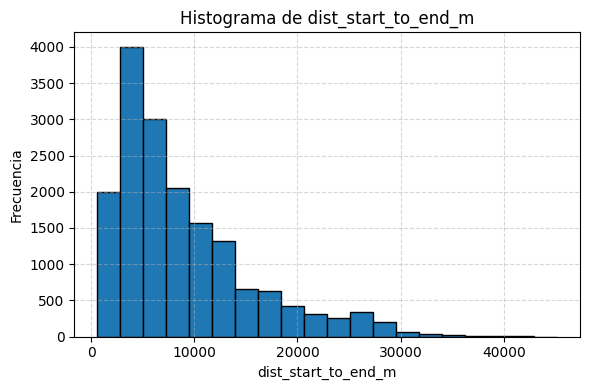

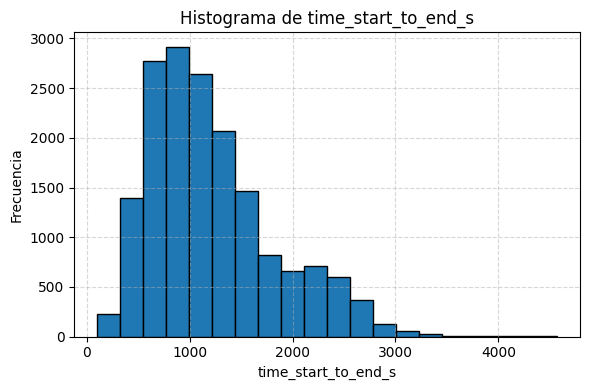

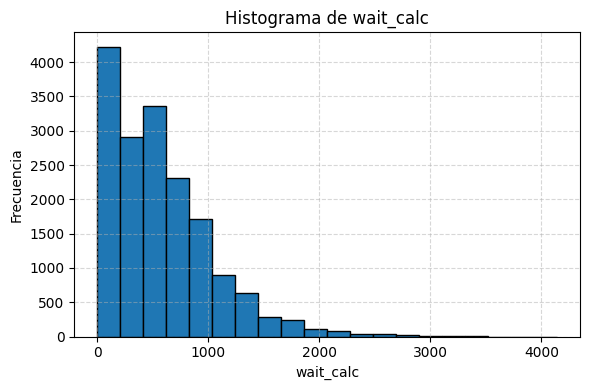

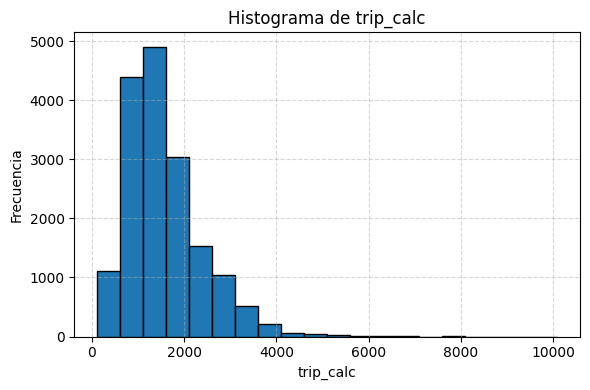

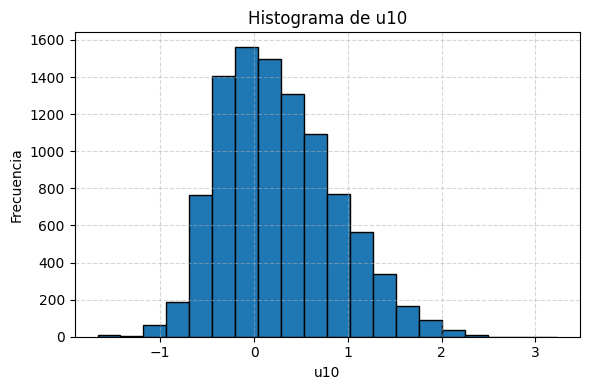

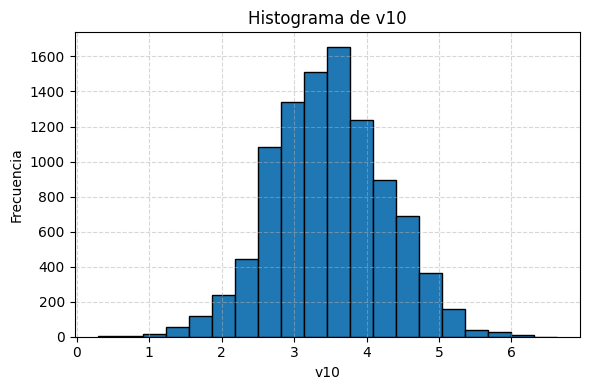

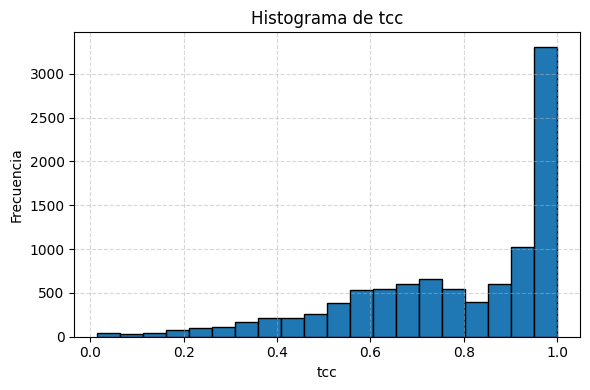

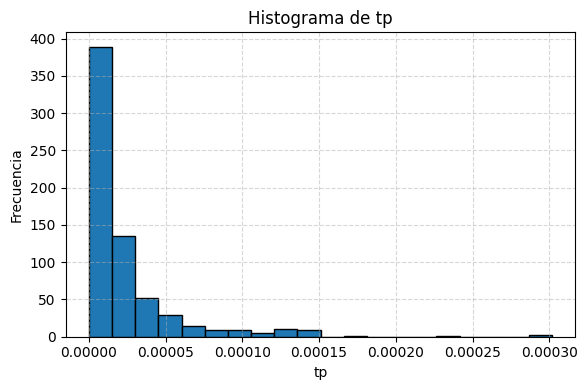

In [19]:
for col in cuantitativas:
    plt.figure(figsize=(6, 4))
    df_drop[col].dropna().hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


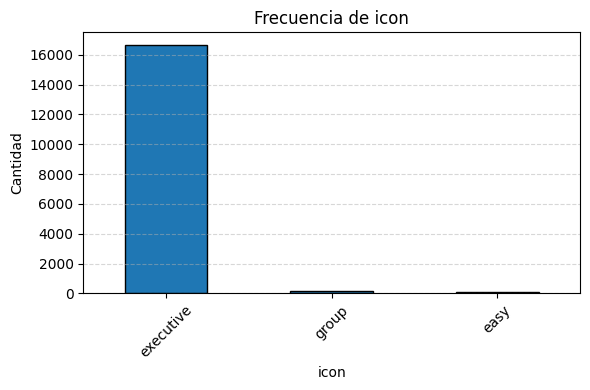

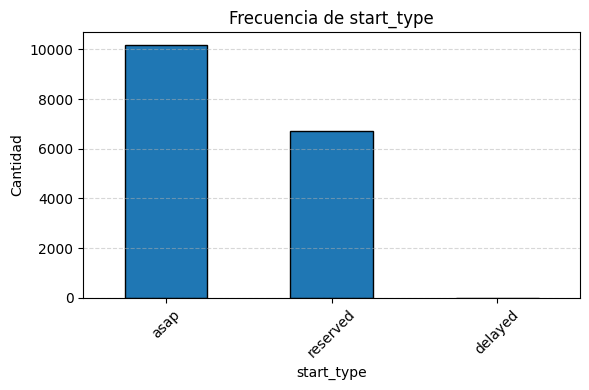

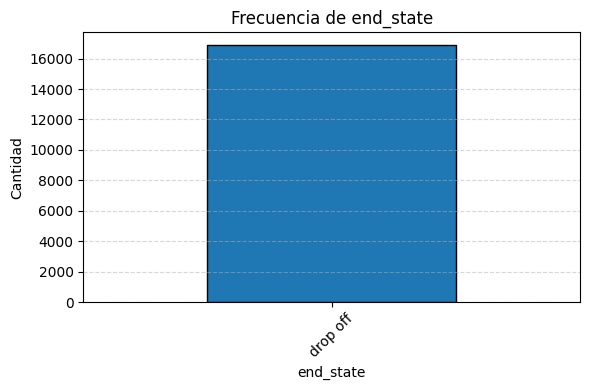

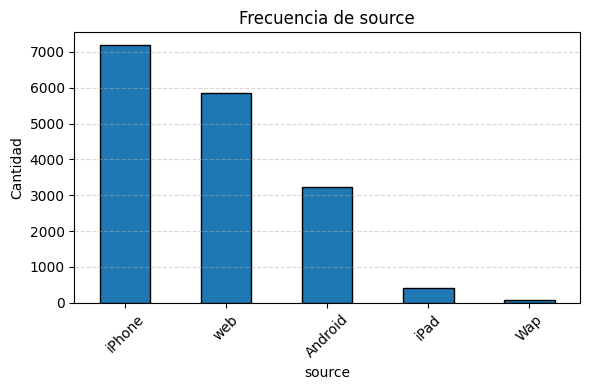

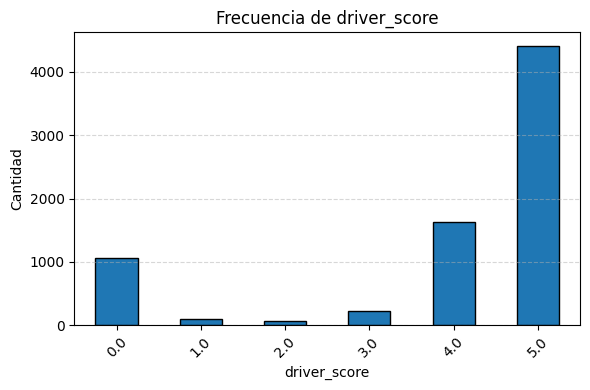

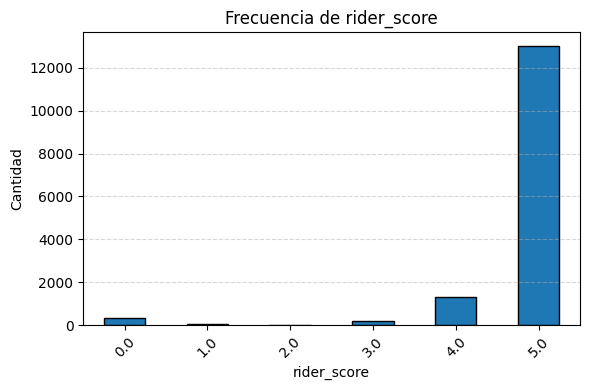

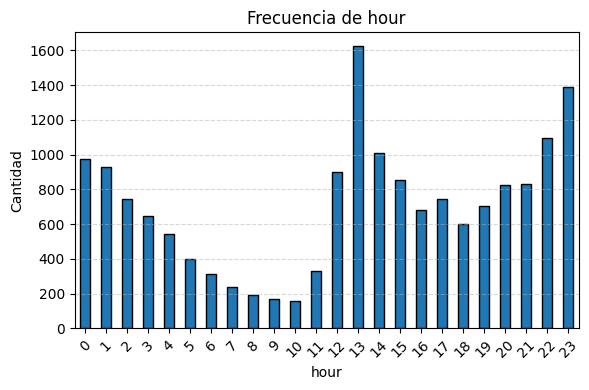

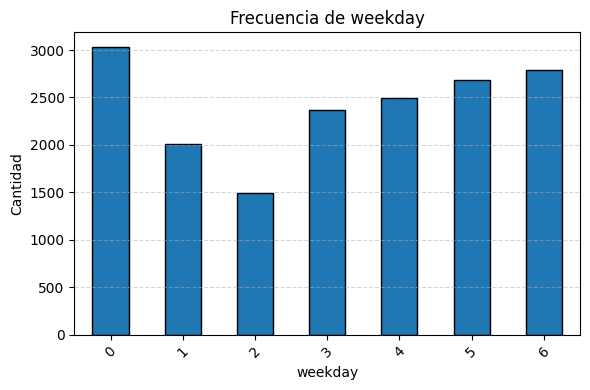

In [20]:
for col in cualitativas:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(df_drop[col]):
        # Ordenar valores únicos de menor a mayor
        orden = sorted(df_drop[col].dropna().unique())
        df_drop[col].value_counts().reindex(orden).plot(kind='bar', edgecolor='black')
    else:
        # Ordenar por frecuencia
        df_drop[col].value_counts().plot(kind='bar', edgecolor='black')

    plt.title(f'Frecuencia de {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [21]:
def detectar_distribucion(df, columnas):
    distribuciones = {
        "normal": stats.norm,
        "exponencial": stats.expon,
        "log-normal": stats.lognorm,
        "gamma": stats.gamma,
        "beta": stats.beta,
        "uniforme": stats.uniform,
        "weibull": stats.weibull_min,
        "chi-cuadrado": stats.chi2,
        "pareto": stats.pareto,
        "cauchy": stats.cauchy,
        "triangular": stats.triang,
        "logística": stats.logistic,
        "rayleigh": stats.rayleigh
    }

    resultados = {}

    for col in columnas:
        datos = df[col].dropna().values

        if len(datos) < 30:
            resultados[col] = "Muy pocos datos"
            continue

        mejores_pvalores = {}

        for nombre, distribucion in distribuciones.items():
            try:
                params = distribucion.fit(datos)
                D, p = stats.kstest(datos, distribucion.name, args=params)
                mejores_pvalores[nombre] = p
            except Exception as e:
                mejores_pvalores[nombre] = f"Error: {e}"

        mejores_pvalores_validos = {k: v for k, v in mejores_pvalores.items() if isinstance(v, float)}
        if mejores_pvalores_validos:
            mejor_distribucion = max(mejores_pvalores_validos, key=mejores_pvalores_validos.get)
            resultados[col] = {
                "mejor ajuste": mejor_distribucion,
                "p-valor": round(mejores_pvalores_validos[mejor_distribucion], 4)
            }
        else:
            resultados[col] = "No se pudo ajustar ninguna distribución"

    return resultados


In [22]:
resultado_distribuciones = detectar_distribucion(df_drop, cuantitativas)

for col, info in resultado_distribuciones.items():
    print(f"{col}: {info}")

c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6626: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:8831: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_c

price: {'mejor ajuste': 'normal', 'p-valor': 0.0}
price_distance: {'mejor ajuste': 'pareto', 'p-valor': 0.0}
price_duration: {'mejor ajuste': 'exponencial', 'p-valor': 0.0}
cost: {'mejor ajuste': 'normal', 'p-valor': 0.0}
cost_duration: {'mejor ajuste': 'normal', 'p-valor': 0.0}
cost_distance: {'mejor ajuste': 'beta', 'p-valor': 0.0}
dist_driver_to_start_m: {'mejor ajuste': 'exponencial', 'p-valor': 0.0}
time_driver_to_start_s: {'mejor ajuste': 'rayleigh', 'p-valor': 0.0}
dist_start_to_end_m: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
time_start_to_end_s: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
wait_calc: {'mejor ajuste': 'rayleigh', 'p-valor': 0.0}
trip_calc: {'mejor ajuste': 'log-normal', 'p-valor': 0.0}
u10: {'mejor ajuste': 'log-normal', 'p-valor': 0.0001}
v10: {'mejor ajuste': 'chi-cuadrado', 'p-valor': 0.0466}
tcc: {'mejor ajuste': 'beta', 'p-valor': 0.0}
tp: {'mejor ajuste': 'beta', 'p-valor': 0.054}


In [23]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Contar frecuencias y tomar las 2 categorías más frecuentes
top2_cats = df_drop['start_type'].value_counts().nlargest(2).index.tolist()

grupo1 = df_drop[df_drop['start_type'] == top2_cats[0]]['price'].dropna()
grupo2 = df_drop[df_drop['start_type'] == top2_cats[1]]['price'].dropna()

print(f"Comparando categorías: '{top2_cats[0]}' vs '{top2_cats[1]}'")

# Test de normalidad Shapiro-Wilk
p_shapiro_g1 = shapiro(grupo1).pvalue
p_shapiro_g2 = shapiro(grupo2).pvalue

print(f"Shapiro-Wilk p-valor grupo '{top2_cats[0]}': {p_shapiro_g1:.4f}")
print(f"Shapiro-Wilk p-valor grupo '{top2_cats[1]}': {p_shapiro_g2:.4f}")

# Test de homogeneidad de varianzas Levene
p_levene = levene(grupo1, grupo2).pvalue
print(f"Levene p-valor (igualdad de varianzas): {p_levene:.4f}")

if p_shapiro_g1 > 0.05 and p_shapiro_g2 > 0.05:
    # Normalidad aceptada
    if p_levene > 0.05:
        stat, p = ttest_ind(grupo1, grupo2, equal_var=True)
        print("Usamos Test t para muestras independientes (varianzas iguales).")
    else:
        stat, p = ttest_ind(grupo1, grupo2, equal_var=False)
        print("Usamos Test t de Welch (varianzas diferentes).")
else:
    stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
    print("No se cumple normalidad, usamos Test Mann-Whitney.")

print(f"Estadístico = {stat:.4f}, p-valor = {p:.4f}")

if p < 0.05:
    print("➡️ Diferencia significativa en price entre grupos de start_type.")
else:
    print("➡️ No hay diferencia significativa en price entre grupos de start_type.")


Comparando categorías: 'asap' vs 'reserved'
Shapiro-Wilk p-valor grupo 'asap': 0.0000
Shapiro-Wilk p-valor grupo 'reserved': 0.0000
Levene p-valor (igualdad de varianzas): 0.0000
No se cumple normalidad, usamos Test Mann-Whitney.
Estadístico = 23485189.5000, p-valor = 0.0000
➡️ Diferencia significativa en price entre grupos de start_type.


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10180.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6695.
  res = hypotest_fun_out(*samples, **kwds)


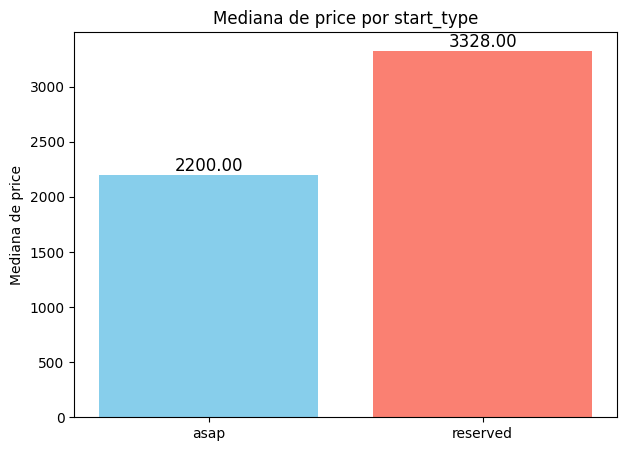

In [24]:
medianas = [grupo1.median(), grupo2.median()]
categorias = [top2_cats[0], top2_cats[1]]

plt.figure(figsize=(7,5))
bars = plt.bar(categorias, medianas, color=['skyblue', 'salmon'])
plt.ylabel('Mediana de price')
plt.title('Mediana de price por start_type')

# Agregar etiquetas con el valor de la mediana arriba de cada barra
for bar, med in zip(bars, medianas):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{med:.2f}',
             ha='center', va='bottom', fontsize=12)

plt.show()

In [25]:
df_drop.select_dtypes(include='number').corr()

,start_lat,start_lon,end_lat,end_lon,driver_start_lat,driver_start_lon,price,price_distance,price_duration,cost,...,u10,v10,d2m,t2m,tcc,tp,hour,weekday,wait_calc,trip_calc
start_lat,1.000000,-0.261418,-0.001427,0.034279,0.681508,-0.231483,0.157941,0.010761,0.056493,0.017244,...,0.081928,0.074293,-0.026440,0.004038,0.010348,-0.033543,0.033652,0.024476,0.090697,0.183704
start_lon,-0.261418,1.000000,0.008285,0.106252,-0.232033,0.783831,-0.049706,0.000432,-0.038766,-0.000414,...,0.038477,0.014867,-0.064032,-0.061854,0.029694,0.002651,0.065656,0.024675,0.014007,-0.028103
end_lat,-0.001427,0.008285,1.000000,-0.338320,0.006936,0.011051,0.222956,0.012770,-0.004352,0.029613,...,-0.017003,-0.025295,-0.010746,-0.018017,0.007181,0.002561,0.012128,0.031981,0.016437,0.293039
end_lon,0.034279,0.106252,-0.338320,1.000000,0.017569,0.102042,-0.101241,0.000337,-0.014521,-0.005712,...,0.066186,0.049360,-0.022471,0.002202,-0.024041,0.041282,0.052287,0.010115,-0.022480,-0.133607
driver_start_lat,0.681508,-0.232033,0.006936,0.017569,1.000000,-0.272112,0.143271,0.011628,0.042443,0.009116,...,0.076165,0.034885,-0.043203,-0.026524,0.004021,0.001350,0.048748,0.024027,0.016284,0.172488
driver_start_lon,-0.231483,0.783831,0.011051,0.102042,-0.272112,1.000000,-0.049385,-0.007270,-0.016189,-0.000903,...,0.088680,0.065239,-0.073718,-0.028230,0.005879,-0.022535,0.092446,0.034051,-0.040253,-0.041897
price,0.157941,-0.049706,0.222956,-0.101241,0.143271,-0.049385,1.000000,0.026247,0.621289,0.103535,...,-0.050883,-0.063382,0.014024,-0.018537,0.027308,-0.012845,-0.046561,-0.032753,0.102580,0.439651
price_distance,0.010761,0.000432,0.012770,0.000337,0.011628,-0.007270,0.026247,1.000000,0.004686,0.004025,...,0.016327,0.003491,-0.003515,0.010015,0.004626,-0.004443,0.009611,0.015612,-0.014697,0.017982
price_duration,0.056493,-0.038766,-0.004352,-0.014521,0.042443,-0.016189,0.621289,0.004686,1.000000,0.072544,...,0.013813,-0.030597,0.034499,0.041490,0.009650,0.003530,0.027259,0.013666,-0.022095,0.053100
cost,0.017244,-0.000414,0.029613,-0.005712,0.009116,-0.000903,0.103535,0.004025,0.072544,1.000000,...,-0.030120,0.019468,-0.030668,-0.031178,-0.008332,0.026148,-0.008654,0.005388,0.015454,0.030974



--- Análisis para variable: icon ---
P-valores test normalidad Shapiro-Wilk:
  easy: p-valor = 3.0358e-15
  executive: p-valor = 6.9611e-103
  group: p-valor = 1.3382e-03
Kruskal-Wallis: estadístico=371.2770, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
                   easy     executive         group
easy       1.000000e+00  8.606679e-19  1.850080e-70
executive  8.606679e-19  1.000000e+00  2.751963e-64
group      1.850080e-70  2.751963e-64  1.000000e+00


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16660.
  res = hypotest_fun_out(*samples, **kwds)


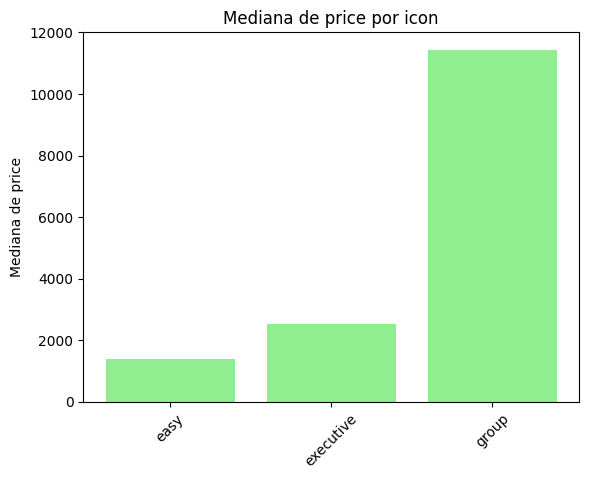


--- Análisis para variable: start_type ---
P-valores test normalidad Shapiro-Wilk:
  asap: p-valor = 1.3308e-91
  delayed: p-valor = 4.0966e-01
  reserved: p-valor = 5.4250e-76
Kruskal-Wallis: estadístico=1198.0148, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
                   asap  delayed       reserved
asap       1.000000e+00  0.66396  6.759098e-262
delayed    6.639601e-01  1.00000   1.000000e+00
reserved  6.759098e-262  1.00000   1.000000e+00


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10180.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6695.
  res = hypotest_fun_out(*samples, **kwds)


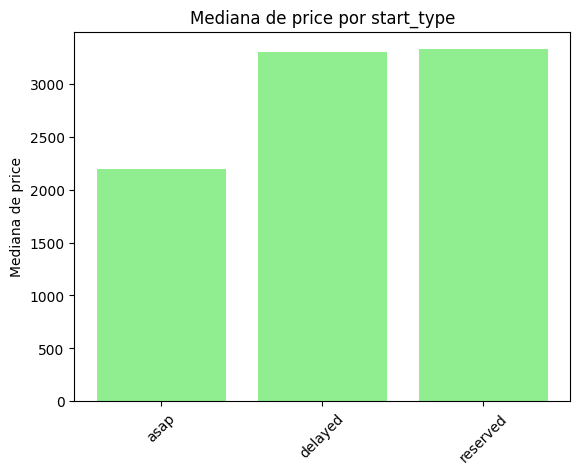


--- Análisis para variable: source ---
P-valores test normalidad Shapiro-Wilk:
  Android: p-valor = 1.1379e-57
  Wap: p-valor = 6.5463e-11
  iPad: p-valor = 2.6738e-20
  iPhone: p-valor = 4.8945e-75
  web: p-valor = 1.6153e-77
Kruskal-Wallis: estadístico=162.0538, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              Android       Wap          iPad        iPhone           web
Android  1.000000e+00  1.000000  3.865955e-14  2.625533e-02  1.061871e-22
Wap      1.000000e+00  1.000000  4.103219e-02  1.000000e+00  1.000000e+00
iPad     3.865955e-14  0.041032  1.000000e+00  7.521573e-11  2.151262e-03
iPhone   2.625533e-02  1.000000  7.521573e-11  1.000000e+00  7.799925e-18
web      1.061871e-22  1.000000  2.151262e-03  7.799925e-18  1.000000e+00


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7182.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5849.
  res = hypotest_fun_out(*samples, **kwds)


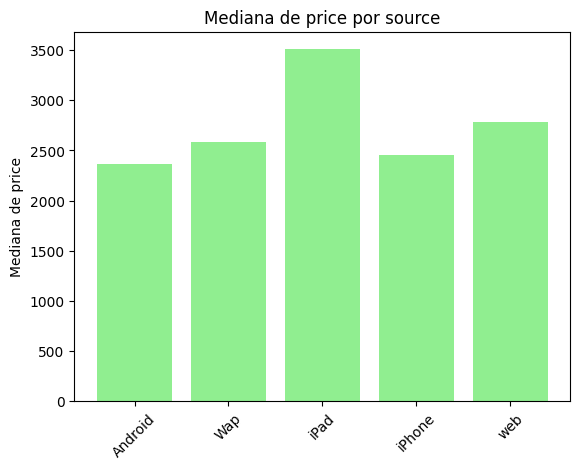


--- Análisis para variable: driver_score ---
P-valores test normalidad Shapiro-Wilk:
  0.0: p-valor = 4.3154e-40
  1.0: p-valor = 9.6152e-10
  2.0: p-valor = 4.0972e-06
  3.0: p-valor = 7.3672e-15
  4.0: p-valor = 1.0792e-43
  5.0: p-valor = 2.1695e-65
Kruskal-Wallis: estadístico=22.3038, p-valor=0.0005
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
          0.0       1.0       2.0       3.0       4.0       5.0
0.0  1.000000  0.011971  0.593475  0.048290  1.000000  1.000000
1.0  0.011971  1.000000  1.000000  1.000000  0.025395  0.021682
2.0  0.593475  1.000000  1.000000  1.000000  0.934759  0.903644
3.0  0.048290  1.000000  1.000000  1.000000  0.122408  0.092274
4.0  1.000000  0.025395  0.934759  0.122408  1.000000  1.000000
5.0  1.000000  0.021682  0.903644  0.092274  1.000000  1.000000


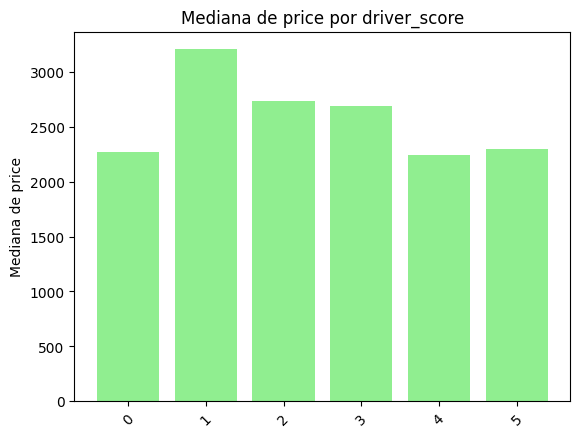


--- Análisis para variable: rider_score ---
P-valores test normalidad Shapiro-Wilk:
  0.0: p-valor = 2.8740e-25
  1.0: p-valor = 2.7316e-08
  2.0: p-valor = 5.0313e-06
  3.0: p-valor = 6.6556e-21
  4.0: p-valor = 3.8062e-38
  5.0: p-valor = 4.1271e-90
Kruskal-Wallis: estadístico=33.7740, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
          0.0       1.0       2.0       3.0       4.0       5.0
0.0  1.000000  1.000000  1.000000  0.998466  0.139487  0.149337
1.0  1.000000  1.000000  1.000000  1.000000  0.301544  0.360887
2.0  1.000000  1.000000  1.000000  1.000000  0.800429  0.938461
3.0  0.998466  1.000000  1.000000  1.000000  0.000308  0.000249
4.0  0.139487  0.301544  0.800429  0.000308  1.000000  1.000000
5.0  0.149337  0.360887  0.938461  0.000249  1.000000  1.000000


c:\Users\Saroka\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12996.
  res = hypotest_fun_out(*samples, **kwds)


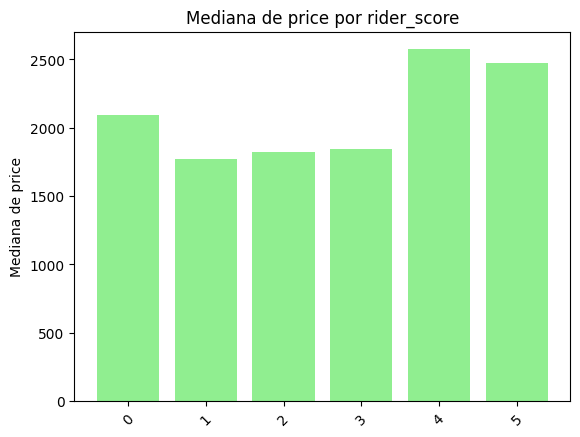


--- Análisis para variable: hour ---
P-valores test normalidad Shapiro-Wilk:
  0: p-valor = 8.8789e-42
  1: p-valor = 1.7251e-38
  2: p-valor = 2.0735e-32
  3: p-valor = 1.1482e-27
  4: p-valor = 6.9352e-27
  5: p-valor = 2.4159e-26
  6: p-valor = 5.2734e-20
  7: p-valor = 1.1392e-15
  8: p-valor = 1.9727e-11
  9: p-valor = 6.5965e-08
  10: p-valor = 1.0857e-06
  11: p-valor = 4.0468e-24
  12: p-valor = 9.6120e-36
  13: p-valor = 8.4753e-57
  14: p-valor = 5.1032e-41
  15: p-valor = 5.6048e-39
  16: p-valor = 2.1777e-37
  17: p-valor = 9.8743e-40
  18: p-valor = 1.7356e-38
  19: p-valor = 2.0438e-35
  20: p-valor = 5.7099e-43
  21: p-valor = 4.7332e-39
  22: p-valor = 2.1529e-42
  23: p-valor = 1.8638e-44
Kruskal-Wallis: estadístico=626.0738, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              0             1             2             3             4   \
0   1.000000e+00  1.000000e+00  1.000000e+00  8.2045

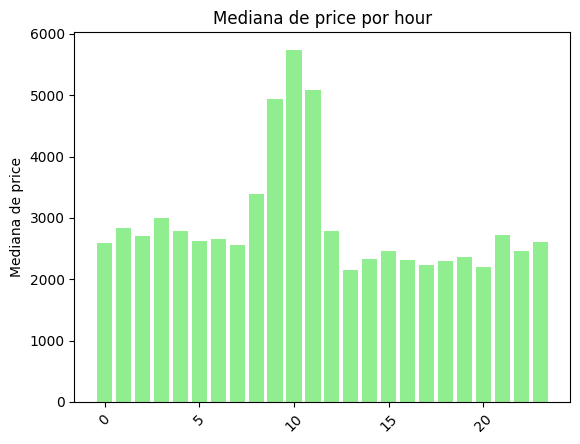


--- Análisis para variable: weekday ---
P-valores test normalidad Shapiro-Wilk:
  0: p-valor = 1.5905e-65
  1: p-valor = 2.6066e-51
  2: p-valor = 5.8636e-47
  3: p-valor = 2.4071e-55
  4: p-valor = 2.3771e-56
  5: p-valor = 5.4116e-63
  6: p-valor = 5.3547e-58
Kruskal-Wallis: estadístico=144.0681, p-valor=0.0000
➡️ Diferencias significativas entre grupos (Kruskal-Wallis).
Test post-hoc Dunn (ajustado Bonferroni):
              0             1             2             3             4  \
0  1.000000e+00  3.739996e-05  3.662179e-10  1.000000e+00  3.861469e-02   
1  3.739996e-05  1.000000e+00  5.852801e-01  1.635597e-05  3.059895e-12   
2  3.662179e-10  5.852801e-01  1.000000e+00  2.024822e-10  2.468765e-18   
3  1.000000e+00  1.635597e-05  2.024822e-10  1.000000e+00  2.582913e-01   
4  3.861469e-02  3.059895e-12  2.468765e-18  2.582913e-01  1.000000e+00   
5  1.983188e-02  5.060114e-13  2.942381e-19  1.596866e-01  1.000000e+00   
6  1.000000e+00  6.472940e-06  4.772556e-11  1.000000e+0

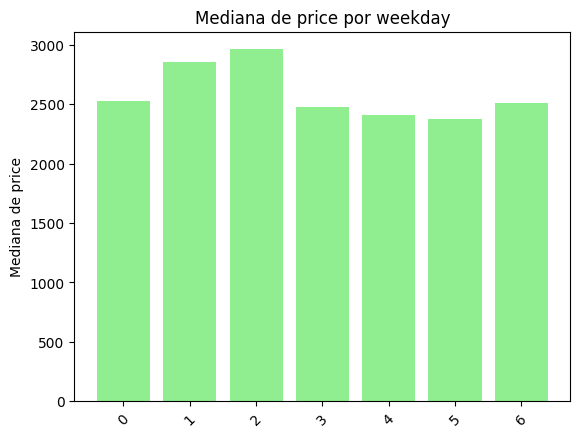

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, f_oneway, kruskal
import scikit_posthocs as sp

# Lo que hace este test basicamente es hacer un anova (pero no literlamente porque no acepta distribucion normal) Es por eso que se usa la mediana (Se podria borrar Dunnet y Los test para la normalidad)

def analizar_cualitativas(df, target_col, cualitativas): # Lo que hace este test basicamente es hacer un anova (pero no literlamente porque no acepta distribucion normal)
    for var in cualitativas:
        print(f"\n--- Análisis para variable: {var} ---")
        grupos = sorted(df[var].dropna().unique())
        datos_por_grupo = [df[df[var] == g][target_col].dropna() for g in grupos]

        # Test de normalidad Shapiro-Wilk por grupo
        normalidad_ok = True
        print("P-valores test normalidad Shapiro-Wilk:")
        for g, datos in zip(grupos, datos_por_grupo):
            if len(datos) < 3:
                print(f"  {g}: Muy pocos datos para test")
                continue
            p_val = shapiro(datos).pvalue
            print(f"  {g}: p-valor = {p_val:.4e}")
            if p_val < 0.05:
                normalidad_ok = False

        if normalidad_ok:
            # Test homogeneidad de varianzas
            p_levene = levene(*datos_por_grupo).pvalue
            print(f"Levene p-valor: {p_levene:.4f}")
            if p_levene > 0.05:
                stat, p = f_oneway(*datos_por_grupo)
                print(f"ANOVA: estadístico={stat:.4f}, p-valor={p:.4f}")
                if p < 0.05:
                    print("➡️ Diferencias significativas entre grupos (ANOVA).")
                else:
                    print("➡️ No diferencias significativas entre grupos (ANOVA).")
                # Gráfico con medias
                medias = [np.mean(datos) for datos in datos_por_grupo]
                plt.bar(grupos, medias, color='skyblue')
                plt.ylabel(f'Media de {target_col}')
                plt.title(f'Media de {target_col} por {var}')
                plt.xticks(rotation=45)
                plt.show()
            else:
                print("Varianzas no homogéneas, se recomienda Welch ANOVA.")
        else:
            # Test no paramétrico Kruskal-Wallis
            stat, p = kruskal(*datos_por_grupo)
            print(f"Kruskal-Wallis: estadístico={stat:.4f}, p-valor={p:.4f}")
            if p < 0.05:
                print("➡️ Diferencias significativas entre grupos (Kruskal-Wallis).")
                # Post-hoc Dunn
                print("Test post-hoc Dunn (ajustado Bonferroni):")
                data = df[[var, target_col]].dropna()
                dunn_res = sp.posthoc_dunn(data, val_col=target_col, group_col=var, p_adjust='bonferroni')
                print(dunn_res)
            else:
                print("➡️ No diferencias significativas entre grupos (Kruskal-Wallis).")
            # Gráfico con medianas
            medianas = [np.median(datos) for datos in datos_por_grupo]
            plt.bar(grupos, medianas, color='lightgreen')
            plt.ylabel(f'Mediana de {target_col}')
            plt.title(f'Mediana de {target_col} por {var}')
            plt.xticks(rotation=45)
            plt.show()

analizar_cualitativas(df_drop, 'price', ['icon','start_type','source','driver_score','rider_score','hour','weekday'])